<h1><font size = 6>Capstone Project: Segmenting and Clustering Neighborhoods in Selangor, Malaysia</font></h1>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology: K-means clustering](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In light of malaysians getting more conscious about fitness and health, in this project we will help a client to try to find an optimal location to open a new fitness centre. This report is targeted to the client who is interested in opening a fitness centre in one of the two districts in Selangor that we will be investigating, specifically the district of Gombak and Hulu Langat of Selangor, Malaysia.

To find the most optimal location, we will be interested in areas whereby there are very little to no existing fitness centres. In particular, fitness centres will comprise of gym, soccer field, sports club, etc. Additionally, we would also be interested in areas whereby there are restaurants nearby as people tend to prefer locations where they can have food after exercising. 

This project will utilize data science to produce the most promising neighborhoods based on the criteria mentioned. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing fitness centres in the neighborhood (any type of fitness related centres)
* number of existing restaurants in the neighborhood

Following data sources will be needed to extract/generate the required information:
* list of neighborhoods in the district of Gombak and Hulu Langat will be extracted from wikepedia page using Python webscraping method
* number of restaurants and fitness centres and their location in every neighborhood will be obtained using **Foursquare API**
* coordinates of neighborhoods will be obtained using **geopy Nominatim**

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import pandas as pd # library for data analysis
import numpy as np # library to handle data in a vectorized manner
import folium # map rendering library
import requests # library to handle requests
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
from sklearn.metrics import silhouette_samples, silhouette_score
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Libraries imported.')

Libraries imported.


We will web scrape the list of neighborhoods we need from the following wikepedia page: <br>
https://en.wikipedia.org/wiki/Selangor

In [2]:
url = 'https://en.wikipedia.org/wiki/Selangor'
wiki_results = pd.read_html(url, match="Sub-districts", flavor='bs4')[0]
wiki_results.head(5)

,Number,Name,Population2010 Census[54],Area (km2),Sub-districts,Note
0,Administrative districts of Selangor.,Administrative districts of Selangor.,Administrative districts of Selangor.,Administrative districts of Selangor.,Administrative districts of Selangor.,Administrative districts of Selangor.
1,1,Gombak,682226,650.08[55],"Ulu Klang, Ampang, Setapak, Batu Caves, Selaya...",The meaning of Gombak is unknown but it is bel...
2,2,Hulu Langat,1156585,829.44[56],"Kajang, Beranang, Cheras, Hulu Langat, Hulu Se...",The name Hulu Langat means the beginning of La...
3,3,Hulu Selangor,198132,"1,740.46[59]","Kuala Kubu Bharu, Sungai Chick, Ulu Yam, Ulu Y...",The name Hulu Selangor means the beginning of ...
4,4,Klang,861189,626.78[62],"Klang, Kapar, Bukit Raja, Port Klang, Pandamar...",The origin of the Klang name is unknown. The R...


##### Data Cleaning
For this project, we are interested in Gombak and Hulu Langat districts of Selangor only. Note that there is a list of neighborhoods for each of them under the 'Sub-districts' column. We will extract these information and convert into clean format that we can use.

In [3]:
msia_neighborhood = pd.DataFrame(columns=['District', 'Neighborhood'])


for nbhood in wiki_results.iloc[1,4].split(', '):
    msia_data_row = {'District': wiki_results.iloc[1,1], 'Neighborhood': nbhood.rstrip('.')}
    msia_neighborhood  = msia_neighborhood .append(msia_data_row, ignore_index=True)
    
for nbhood in wiki_results.iloc[2,4].split(', '):
    msia_data_row = {'District': wiki_results.iloc[2,1], 'Neighborhood': nbhood.rstrip('.')}
    msia_neighborhood  = msia_neighborhood .append(msia_data_row, ignore_index=True)
    
msia_neighborhood.head(5)

,District,Neighborhood
0,Gombak,Ulu Klang
1,Gombak,Ampang
2,Gombak,Setapak
3,Gombak,Batu Caves
4,Gombak,Selayang


Now, lets get the latitude and longitude coordiantes using Nonimatim. Note that as the nominatim function is not comprehensive to get coordinates for all the neighborhoods that we have, we will temporarily set '999' for those with missing coordinates, so that we can identify them and remove them from our study. 

There are number of ways to handle missing data/information. For example, we could spend more time to extract coordiantes externally from other sources for those neighborhoods that nominatim function could not extract coordinates from. In this study, we have chosen to remove them from our study, as our client agreed that the those neighborhoods are not as developed as the other areas and are not of our client's interest.

In [4]:
lat_list=[]
lon_list=[]
geolocator = Nominatim(user_agent="msia_explorer")

for row in range(msia_neighborhood.shape[0]):
    address  = msia_neighborhood.iloc[row,1] + ", " + msia_neighborhood.iloc[row,0] + ", Malaysia"
    location = geolocator.geocode(address)    
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = 999
        longitude = 999
    lat_list += [latitude]
    lon_list += [longitude]
    print('The geographical coordinate of {} are {}, {}.'.format(address, latitude, longitude))


The geographical coordinate of Ulu Klang, Gombak, Malaysia are 3.0975692, 101.7576118.
The geographical coordinate of Ampang, Gombak, Malaysia are 3.15025555, 101.76021009194159.
The geographical coordinate of Setapak, Gombak, Malaysia are 3.190238, 101.7061755.
The geographical coordinate of Batu Caves, Gombak, Malaysia are 3.2374514000000003, 101.68122596587875.
The geographical coordinate of Selayang, Gombak, Malaysia are 3.2537121, 101.6539012.
The geographical coordinate of Rawang, Gombak, Malaysia are 3.3188465000000003, 101.57498307672526.
The geographical coordinate of Taman Templer, Gombak, Malaysia are 3.297962, 101.6374273.
The geographical coordinate of Sungai Buloh, Gombak, Malaysia are 3.2063138, 101.58175743452605.
The geographical coordinate of Kundang, Gombak, Malaysia are 3.2833333, 101.51667.
The geographical coordinate of Batu 20, Gombak, Malaysia are 3.2381345, 101.6843388.
The geographical coordinate of Kampung Sungai Pusu, Gombak, Malaysia are 999, 999.
The geogr

Now, let's append the coordinates information to our msia_neighborhood dataframe.

In [5]:
msia_neighborhood['Latitude'] = lat_list
msia_neighborhood['Longitude'] = lon_list

Next, we filter out those coordinates that we said we will be removing ('999').

In [6]:
new_msia_neighborhood = msia_neighborhood[msia_neighborhood["Latitude"]<900]
new_msia_neighborhood.reset_index(inplace=True)

Now, lets check the first few rows to make sure that we have gotten the right information and format as we want.

In [7]:
new_msia_neighborhood.head(5)

,index,District,Neighborhood,Latitude,Longitude
0,0,Gombak,Ulu Klang,3.097569,101.757612
1,1,Gombak,Ampang,3.150256,101.760210
2,2,Gombak,Setapak,3.190238,101.706176
3,3,Gombak,Batu Caves,3.237451,101.681226
4,4,Gombak,Selayang,3.253712,101.653901


That looks good! Let's check the shape of the dataframe also to understand how many neighborhoods that we will be analysing.

In [8]:
new_msia_neighborhood.shape

(23, 5)

Now, let's first visualize the neighborhoods in Gombak and Hulu Langat of Selangor that we will be analyzing.

In [9]:
address = 'Selangor, Malaysia'
geolocator = Nominatim(user_agent="msia_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Selangor, Malaysia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Selangor, Malaysia are 3.2083304, 101.304146.


In [1]:
import folium # map rendering library
map_msia = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(new_msia_neighborhood['Latitude'], new_msia_neighborhood['Longitude'], new_msia_neighborhood['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_msia)  
map_msia

NameError: name 'latitude' is not defined

<img src="files\map_msia.jpg">

##### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on nearby venues in each neighborhood.

In [11]:
CLIENT_ID = 'MVTS2VVJSKLCOSADN3WPXXISXTLU1U53FIAA4SL3S4BPKSDQ' # your Foursquare ID
CLIENT_SECRET = 'N0MDBGZ0FQUUXDK5WFBB2THLELTO3HVEBCTJCHZXXJG1BQYH' # your Foursquare Secret
VERSION = '20210724' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Let's create a function that will get the top 100 venues within a radius of 2000 meters for each neighborhood.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

let's call the function we created to get the list of venues for each neighborhood.

In [13]:
msia_venues = getNearbyVenues(names=new_msia_neighborhood['Neighborhood'],
                                   latitudes=new_msia_neighborhood['Latitude'],
                                   longitudes=new_msia_neighborhood['Longitude']
                                  )

Ulu Klang
Ampang
Setapak
Batu Caves
Selayang
Rawang
Taman Templer
Sungai Buloh
Kundang
Batu 20
Kajang
Beranang
Cheras
Hulu Langat
Hulu Semenyih
Sungai Lui
Sri nanding
Simpang Balak
Kampung Sungai Tangkas
Desa Raya
Sungai Raya
Batu 26
Batu 23


Let's check the size of the resulting dataframe

In [14]:
print(msia_venues.shape)
msia_venues

(1547, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ulu Klang,3.097569,101.757612,Bukit Segar Jaya 2,3.095194,101.758607,Park
1,Ulu Klang,3.097569,101.757612,Ketumbar Hill Jungle Trekking,3.103212,101.753537,Trail
2,Ulu Klang,3.097569,101.757612,Top Of Ketumbar Hill,3.100507,101.756392,Dog Run
3,Ulu Klang,3.097569,101.757612,Bukit Hatamas,3.096870,101.763995,Scenic Lookout
4,Ulu Klang,3.097569,101.757612,Mama and Son 媽仔板面,3.091231,101.762052,Noodle House
...,...,...,...,...,...,...,...
1542,Batu 23,3.154591,101.843534,"Impian Country Resort, Hulu Langat",3.156223,101.826682,Campground
1543,Batu 23,3.154591,101.843534,Impian Country Resort,3.156192,101.826565,Outdoors & Recreation
1544,Batu 23,3.154591,101.843534,Kingfisher Camp,3.153634,101.826353,Campground
1545,Batu 23,3.154591,101.843534,King Fisher Resort Hulu Langat,3.153891,101.826195,Campground


Let's check how many venues were returned for each neighborhood.

In [15]:
msia_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ampang,100,100,100,100,100,100
Batu 20,100,100,100,100,100,100
Batu 23,24,24,24,24,24,24
Batu 26,37,37,37,37,37,37
Batu Caves,100,100,100,100,100,100
Beranang,12,12,12,12,12,12
Cheras,100,100,100,100,100,100
Desa Raya,36,36,36,36,36,36
Hulu Langat,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

In [16]:
print('There are {} uniques categories.'.format(len(msia_venues['Venue Category'].unique())))

There are 183 uniques categories.


## Methodology <a name="methodology"></a>

Now, we have the neighborhoods data of Gombak and Hulu Langat **(23 neighborhoods)**. We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of 1547 venues have been obtained and 183 unique categories. 

Before proceeding to clustering, we will perform one hot encoding on the neighborhood data. One hot encoding allows the representation of categorical data to be more expressive and it enables the data to work with machine learning algorithms.

To perform clustering, we will use an unsupervised machine learning algorithm called **K-means**. K-means algorithm starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids. It halts creating and optimizing clusters when either:
* The centroids have stabilized — there is no change in their values because the clustering has been successful.
* The defined number of iterations has been achieved.

Let's perform one hot encoding using pandas 'get_dummies' method.

In [17]:
# one hot encoding
msia_onehot = pd.get_dummies(msia_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
msia_onehot['Neighborhood'] = msia_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [msia_onehot.columns[-1]] + list(msia_onehot.columns[:-1])
msia_onehot = msia_onehot[fixed_columns]

msia_onehot.head()

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [18]:
msia_onehot.shape

(1547, 183)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. We can use this information to perform k-means clustering later on.

In [19]:
msia_grouped = msia_onehot.groupby('Neighborhood').mean().reset_index()
msia_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Arcade,Art Gallery,Asian Restaurant,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Volleyball Court,Water Park,Women's Store,Yoga Studio
0,Ampang,0.000000,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.010000,0.060000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
1,Batu 20,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.060000,...,0.010000,0.00,0.00,0.010000,0.00,0.00,0.00,0.000000,0.00,0.00
2,Batu 23,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.041667,0.000000,0.000000,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
3,Batu 26,0.000000,0.000000,0.00,0.00,0.027027,0.000000,0.000000,0.000000,0.135135,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
4,Batu Caves,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.070000,...,0.010000,0.00,0.00,0.010000,0.00,0.00,0.00,0.000000,0.00,0.00
5,Beranang,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
6,Cheras,0.000000,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.060000,...,0.010000,0.01,0.00,0.010000,0.01,0.00,0.00,0.000000,0.01,0.00
7,Desa Raya,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.027778,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
8,Hulu Langat,0.000000,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.050000,...,0.010000,0.01,0.00,0.010000,0.01,0.00,0.00,0.000000,0.01,0.00
9,Hulu Semenyih,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.041667,0.00,0.00


Let's print each neighborhood along with the top 5 most common venues.

In [20]:
num_top_venues = 5

for hood in msia_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = msia_grouped[msia_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ampang----
                       venue  freq
0           Malay Restaurant  0.11
1         Chinese Restaurant  0.10
2          Korean Restaurant  0.06
3           Asian Restaurant  0.06
4  Middle Eastern Restaurant  0.05


----Batu 20----
                venue  freq
0    Malay Restaurant  0.13
1    Asian Restaurant  0.06
2   Indian Restaurant  0.05
3  Chinese Restaurant  0.04
4     Motorcycle Shop  0.04


----Batu 23----
                   venue  freq
0       Malay Restaurant  0.17
1             Campground  0.12
2             Restaurant  0.12
3                  River  0.08
4  Indonesian Restaurant  0.04


----Batu 26----
              venue  freq
0  Malay Restaurant  0.24
1  Asian Restaurant  0.14
2   Thai Restaurant  0.11
3        Restaurant  0.08
4            Bistro  0.05


----Batu Caves----
                venue  freq
0    Malay Restaurant  0.16
1    Asian Restaurant  0.07
2  Chinese Restaurant  0.06
3   Indian Restaurant  0.06
4  Seafood Restaurant  0.05


----Beranang----
   

First, let's write a function to sort the venues in descending order.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = msia_grouped['Neighborhood']

for ind in np.arange(msia_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(msia_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ampang,Malay Restaurant,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant,Café,Restaurant,Dessert Shop,Food Truck,Ice Cream Shop
1,Batu 20,Malay Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant,Motorcycle Shop,Convenience Store,Residential Building (Apartment / Condo),Miscellaneous Shop,Fast Food Restaurant,Seafood Restaurant
2,Batu 23,Malay Restaurant,Campground,Restaurant,River,Indonesian Restaurant,Chinese Restaurant,Outdoors & Recreation,Breakfast Spot,Mountain,Convenience Store
3,Batu 26,Malay Restaurant,Asian Restaurant,Thai Restaurant,Restaurant,Bistro,Pizza Place,Sandwich Place,Night Market,Other Great Outdoors,Seafood Restaurant
4,Batu Caves,Malay Restaurant,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Seafood Restaurant,Thai Restaurant,Diner,Fast Food Restaurant,Convenience Store,Miscellaneous Shop


We are now ready to perform k-means clustering. Before that, we will plot a graph of silhouette score for different number of clusters to help us identify the most optimal number of clusters.

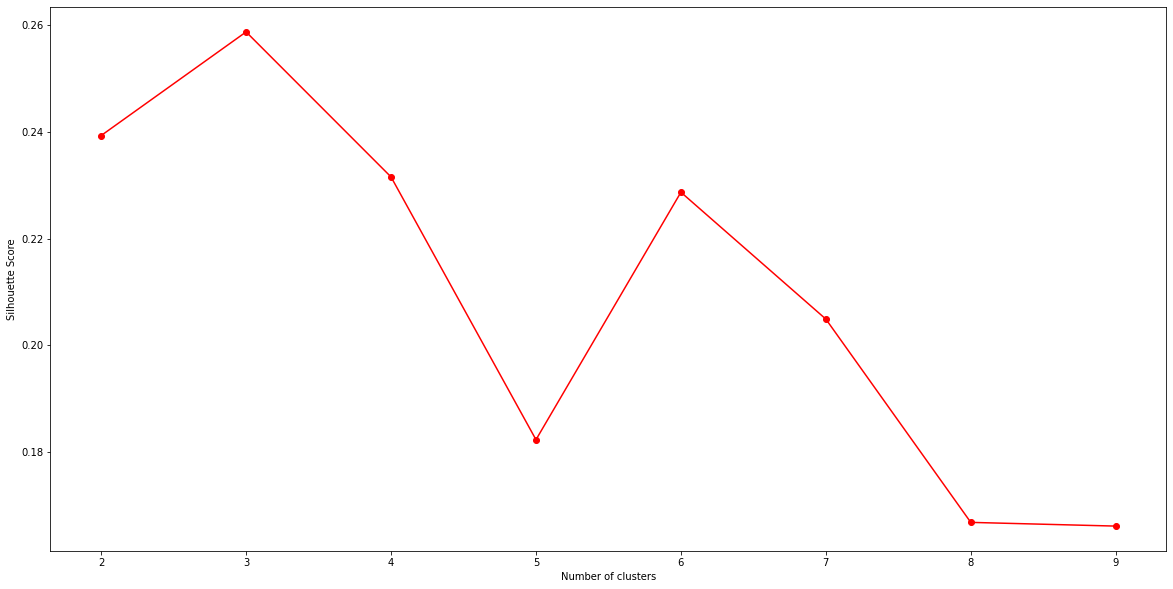

In [23]:
msia_grouped_clustering = msia_grouped.drop('Neighborhood', axis=1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans2 = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(msia_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(msia_grouped_clustering, kmeans2)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

Based on the graph, we should proceed with 5 number of clusters as it is the most optimal.

In [24]:
# set number of clusters
kclusters = 5

msia_grouped_clustering = msia_grouped.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(msia_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([4, 3, 2, 1, 3, 1, 4, 1, 4, 4, 4, 3, 0, 4, 3, 4, 3, 1, 4, 2, 4, 0,
       4])

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [26]:
msia_merged = new_msia_neighborhood
msia_merged = msia_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
msia_merged.head()

,index,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Gombak,Ulu Klang,3.097569,101.757612,4,Chinese Restaurant,Convenience Store,Noodle House,Café,Indian Restaurant,Asian Restaurant,Trail,Malay Restaurant,Thai Restaurant,Scenic Lookout
1,1,Gombak,Ampang,3.150256,101.760210,4,Malay Restaurant,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant,Café,Restaurant,Dessert Shop,Food Truck,Ice Cream Shop
2,2,Gombak,Setapak,3.190238,101.706176,4,Chinese Restaurant,Malay Restaurant,Asian Restaurant,Coffee Shop,Café,Thai Restaurant,Dance Studio,Motorcycle Shop,Bubble Tea Shop,Theater
3,3,Gombak,Batu Caves,3.237451,101.681226,3,Malay Restaurant,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Seafood Restaurant,Thai Restaurant,Diner,Fast Food Restaurant,Convenience Store,Miscellaneous Shop
4,4,Gombak,Selayang,3.253712,101.653901,3,Malay Restaurant,Asian Restaurant,Chinese Restaurant,Café,Seafood Restaurant,Food Truck,Burger Joint,Night Market,Halal Restaurant,Grocery Store


Finally, let's visualize the resulting clusters.

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(msia_merged['Latitude'], msia_merged['Longitude'], msia_merged['Neighborhood'], msia_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Now, let's write two functions that will help us identify the number of fitness centres and number of restaurants within a particular neighborhood.

In [28]:
def count_fitness_centre(neigh_list):
    count_gym = 0
    count_soccer_field = 0
    count_sports_club = 0
    for area in neigh_list:
        count_gym          += msia_venues[(msia_venues['Neighborhood']== area) & ((msia_venues['Venue Category']=='Gym / Fitness Center') 
                                                                               | (msia_venues['Venue Category']=='Gym'))].shape[0]
        count_soccer_field += msia_venues[(msia_venues['Neighborhood']== area) & (msia_venues['Venue Category']=='Soccer Field')].shape[0]
        count_sports_club  += msia_venues[(msia_venues['Neighborhood']== area) & (msia_venues['Venue Category']=='Sports Club')].shape[0]
    return count_gym, count_soccer_field, count_sports_club
    
def count_restaurant(neigh_list):
    count_restaurant = 0
    for area in neigh_list:
        count_restaurant += msia_venues[(msia_venues['Neighborhood']== area) & (msia_venues['Venue Category'].str.contains('Restaurant'))].shape[0]
    return count_restaurant

## Analysis <a name="analysis"></a>

Now that we have completed k-means clustering, let's analyze each cluster individually to determine the most optimal location that our client can open a fitness centre.

##### Cluster 1

In [29]:
cluster1 = msia_merged.loc[msia_merged['Cluster Labels'] == 0, msia_merged.columns[[0] + list(range(1, msia_merged.shape[1]))]]
cluster1

,index,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,6,Gombak,Taman Templer,3.297962,101.637427,0,Golf Course,Park,Resort,Art Gallery,Bowling Alley,Indoor Play Area,Lake,Malay Restaurant,Mountain,Outdoors & Recreation
8,8,Gombak,Kundang,3.283333,101.516670,0,Rest Area,Golf Course,Chinese Restaurant,Malay Restaurant,Lake,Food Truck,Animal Shelter,Playground,Asian Restaurant,Water Park


In [30]:
fitness_count1 = count_fitness_centre(cluster1['Neighborhood'])
restaurant_count1 = count_restaurant(cluster1['Neighborhood'])
print('There are {}, {}, {} of gym, soccer field and sports club in this cluster.'.format(fitness_count1[0],fitness_count1[1],fitness_count1[2]))
print('There are {} of restaurants in this cluster.'.format(restaurant_count1))

There are 1, 0, 0 of gym, soccer field and sports club in this cluster.
There are 8 of restaurants in this cluster.


##### Cluster 2

In [31]:
cluster2 = msia_merged.loc[msia_merged['Cluster Labels'] == 1, msia_merged.columns[[0] + list(range(1, msia_merged.shape[1]))]]
cluster2

,index,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,12,Hulu Langat,Beranang,2.874611,101.871986,1,Malay Restaurant,Café,Seafood Restaurant,Bus Station,Restaurant,Flea Market,Diner,Asian Restaurant,Golf Course,Botanical Garden
16,22,Hulu Langat,Sri nanding,3.100961,101.804673,1,Malay Restaurant,Thai Restaurant,Asian Restaurant,Restaurant,Bistro,Chinese Restaurant,Convenience Store,Night Market,Cupcake Shop,Seafood Restaurant
19,28,Hulu Langat,Desa Raya,3.083725,101.788354,1,Malay Restaurant,Thai Restaurant,Seafood Restaurant,Fast Food Restaurant,Restaurant,Hot Spring,Breakfast Spot,Gym / Fitness Center,Bistro,Gym
21,30,Hulu Langat,Batu 26,3.097290,101.799105,1,Malay Restaurant,Asian Restaurant,Thai Restaurant,Restaurant,Bistro,Pizza Place,Sandwich Place,Night Market,Other Great Outdoors,Seafood Restaurant


In [32]:
fitness_count2 = count_fitness_centre(cluster2['Neighborhood'])
restaurant_count2 = count_restaurant(cluster2['Neighborhood'])
print('There are {}, {}, {} of gym, soccer field and sports club in this cluster.'.format(fitness_count2[0],fitness_count2[1],fitness_count2[2]))
print('There are {} of restaurants in this cluster.'.format(restaurant_count2))

There are 2, 0, 0 of gym, soccer field and sports club in this cluster.
There are 77 of restaurants in this cluster.


##### Cluster 3

In [33]:
cluster3 = msia_merged.loc[msia_merged['Cluster Labels'] == 2, msia_merged.columns[[0] + list(range(1, msia_merged.shape[1]))]]
cluster3

,index,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,20,Hulu Langat,Sungai Lui,3.171175,101.861240,2,Malay Restaurant,River,Restaurant,Asian Restaurant,Breakfast Spot,Seafood Restaurant,Park,Campground,Convenience Store,Cupcake Shop
22,31,Hulu Langat,Batu 23,3.154591,101.843534,2,Malay Restaurant,Campground,Restaurant,River,Indonesian Restaurant,Chinese Restaurant,Outdoors & Recreation,Breakfast Spot,Mountain,Convenience Store


In [34]:
fitness_count3 = count_fitness_centre(cluster3['Neighborhood'])
restaurant_count3 = count_restaurant(cluster3['Neighborhood'])
print('There are {}, {}, {} of gym, soccer field and sports club in this cluster.'.format(fitness_count3[0],fitness_count3[1],fitness_count3[2]))
print('There are {} of restaurants in this cluster.'.format(restaurant_count3))

There are 0, 0, 0 of gym, soccer field and sports club in this cluster.
There are 19 of restaurants in this cluster.


##### Cluster 4

In [35]:
cluster4 = msia_merged.loc[msia_merged['Cluster Labels'] == 3, msia_merged.columns[[0] + list(range(1, msia_merged.shape[1]))]]
cluster4

,index,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,3,Gombak,Batu Caves,3.237451,101.681226,3,Malay Restaurant,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Seafood Restaurant,Thai Restaurant,Diner,Fast Food Restaurant,Convenience Store,Miscellaneous Shop
4,4,Gombak,Selayang,3.253712,101.653901,3,Malay Restaurant,Asian Restaurant,Chinese Restaurant,Café,Seafood Restaurant,Food Truck,Burger Joint,Night Market,Halal Restaurant,Grocery Store
9,9,Gombak,Batu 20,3.238135,101.684339,3,Malay Restaurant,Asian Restaurant,Indian Restaurant,Chinese Restaurant,Motorcycle Shop,Convenience Store,Residential Building (Apartment / Condo),Miscellaneous Shop,Fast Food Restaurant,Seafood Restaurant
17,23,Hulu Langat,Simpang Balak,3.015306,101.766096,3,Malay Restaurant,Restaurant,Convenience Store,Asian Restaurant,Market,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Halal Restaurant,Thai Restaurant
18,25,Hulu Langat,Kampung Sungai Tangkas,2.948025,101.789967,3,Malay Restaurant,Convenience Store,Café,Thai Restaurant,Asian Restaurant,Burger Joint,Italian Restaurant,Indian Restaurant,Furniture / Home Store,Pizza Place


In [36]:
fitness_count4 = count_fitness_centre(cluster4['Neighborhood'])
restaurant_count4 = count_restaurant(cluster4['Neighborhood'])
print('There are {}, {}, {} of gym, soccer field and sports club in this cluster.'.format(fitness_count4[0],fitness_count4[1],fitness_count4[2]))
print('There are {} of restaurants in this cluster.'.format(restaurant_count4))

There are 7, 1, 0 of gym, soccer field and sports club in this cluster.
There are 203 of restaurants in this cluster.


##### Cluster 5

In [37]:
cluster5 = msia_merged.loc[msia_merged['Cluster Labels'] == 4, msia_merged.columns[[0] + list(range(1, msia_merged.shape[1]))]]
cluster5

,index,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Gombak,Ulu Klang,3.097569,101.757612,4,Chinese Restaurant,Convenience Store,Noodle House,Café,Indian Restaurant,Asian Restaurant,Trail,Malay Restaurant,Thai Restaurant,Scenic Lookout
1,1,Gombak,Ampang,3.150256,101.760210,4,Malay Restaurant,Chinese Restaurant,Korean Restaurant,Asian Restaurant,Middle Eastern Restaurant,Café,Restaurant,Dessert Shop,Food Truck,Ice Cream Shop
2,2,Gombak,Setapak,3.190238,101.706176,4,Chinese Restaurant,Malay Restaurant,Asian Restaurant,Coffee Shop,Café,Thai Restaurant,Dance Studio,Motorcycle Shop,Bubble Tea Shop,Theater
5,5,Gombak,Rawang,3.318847,101.574983,4,Chinese Restaurant,Malay Restaurant,Restaurant,Asian Restaurant,Indian Restaurant,Seafood Restaurant,Convenience Store,Café,Sushi Restaurant,Shopping Mall
7,7,Gombak,Sungai Buloh,3.206314,101.581757,4,Chinese Restaurant,Malay Restaurant,Asian Restaurant,Café,Convenience Store,Burger Joint,Seafood Restaurant,Restaurant,Thai Restaurant,Gym
10,11,Hulu Langat,Kajang,2.983234,101.790659,4,Malay Restaurant,Chinese Restaurant,Asian Restaurant,Food Truck,Restaurant,Convenience Store,Indian Restaurant,Thai Restaurant,Coffee Shop,Steakhouse
12,13,Hulu Langat,Cheras,3.073076,101.762685,4,Chinese Restaurant,Malay Restaurant,Asian Restaurant,Indian Restaurant,Thai Restaurant,Food Court,Restaurant,Noodle House,Convenience Store,Halal Restaurant
13,14,Hulu Langat,Hulu Langat,3.072769,101.762025,4,Chinese Restaurant,Malay Restaurant,Indian Restaurant,Asian Restaurant,Restaurant,Convenience Store,Food Court,Noodle House,Thai Restaurant,Seafood Restaurant
14,15,Hulu Langat,Hulu Semenyih,2.944485,101.876028,4,Restaurant,Chinese Restaurant,Convenience Store,Asian Restaurant,Malay Restaurant,Garden,Café,Coffee Shop,Gym,Mountain
20,29,Hulu Langat,Sungai Raya,3.065522,101.778496,4,Chinese Restaurant,Asian Restaurant,Food Court,Restaurant,Indian Restaurant,Café,Noodle House,Malay Restaurant,Convenience Store,Thai Restaurant


In [38]:
fitness_count5 = count_fitness_centre(cluster5['Neighborhood'])
restaurant_count5 = count_restaurant(cluster5['Neighborhood'])
print('There are {}, {}, {} of gym, soccer field and sports club in this cluster.'.format(fitness_count5[0],fitness_count5[1],fitness_count5[2]))
print('There are {} of restaurants in this cluster.'.format(restaurant_count5))

There are 15, 2, 1 of gym, soccer field and sports club in this cluster.
There are 467 of restaurants in this cluster.


Now, let's have 2 plots and one table to present the results.

Text(0.5, 1.0, 'Number of restaurant per Cluster')

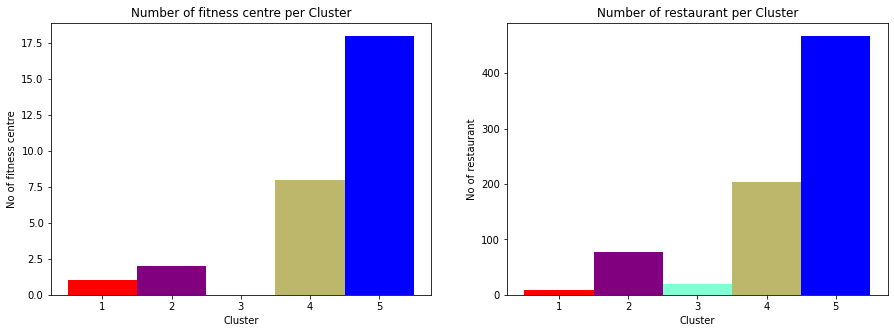

In [39]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of fitness centre)
plt.subplot(1,2,1)
cluster = (1,2,3,4,5)
yaxis1 = [sum(fitness_count1),sum(fitness_count2),sum(fitness_count3),sum(fitness_count4),sum(fitness_count5)]
plt.bar(cluster, yaxis1, align='center', width=1, color=['red', 'purple','aquamarine', 'darkkhaki','blue'])
plt.ylabel('No of fitness centre')
plt.xlabel('Cluster')
plt.title('Number of fitness centre per Cluster')


# Plot-2 ( Number of restaurant)
plt.subplot(1,2,2)
cluster = (1,2,3,4,5)
yaxis2 = [restaurant_count1,restaurant_count2,restaurant_count3,restaurant_count4,restaurant_count5]
plt.bar(cluster, yaxis2, align='center', width=1, color=['red', 'purple','aquamarine', 'darkkhaki','blue'])
plt.ylabel('No of restaurant')
plt.xlabel('Cluster')
plt.title('Number of restaurant per Cluster')


In [40]:
results_df = pd.DataFrame(columns=['Cluster', 'No. of fitness centre', 'No. of restaurant'])
results_df['Cluster'] = cluster
results_df['No. of fitness centre'] = yaxis1
results_df['No. of restaurant'] = yaxis2
results_df.set_index('Cluster', inplace=True)
results_df

,No. of fitness centre,No. of restaurant
Cluster,,
1,1,8
2,2,77
3,0,19
4,8,203
5,18,467


## Results and Discussion <a name="results"></a>

As seen from the analysis section above, clusters 4 and 5 have a lot of restaurants and fitness centres, thereby making it not optimal to meet our objectives as it will be a very competitive location. Our objective is to select a location whereby there are none or very few fitness centres, as well as having some good amounts of restaurants. Having some good amounts of restaurants is beneficial as people who exercise tend to prefer these locations because they can have meals right after exercising.

Cluster 2 is not as optimal as well because it already has 2 fitness centres. Cluster 1 is fine as it has 1 fitness centre and 8 restaurants.

Cluster 3 has 0 fitness centre and 19 restaurants within the neighborhood, therefore making it the most optimal location to open a new fitness centre. There is zero competition within the location and has a good amount of restaurants nearby.



## Conclusion <a name="conclusion"></a>

The purpose of this study is to find the most optimal location to open a new fitness centre that can satisfy our stakeholder's objectives. The objectives that influence the final decision are the number of fitness centres around (competition) and number of restaurants nearby. Number of restaurant nearby is a consideration because it is of our view that having restaurants nearby complement fitness centres as people who exercise tend to like these locations.

We have web scraped the list of neighborhoods from wikepedia site and used Foursquare API to explore nearby venues for each neighborhood. Next, we have also used unsupervised machine learning K-means algorithm to cluster similar neighborhoods. Out of the 5 clusters produced by K-means, we have selected clsuter 3 as our best option as there is no competition (0 fitness centre), and also have a good amount of restaurants nearby. Cluster 3 consists of Sungai Lui and Batu 23 neighborhoods.